# Load data of different format published by xcube server's STAC

This notebook shows an example how to load data of different format published by xcube server's STAC. 

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac), following the [README](../README.md).

Now, we first import everything we need:

In [1]:
from xcube.core.store import new_data_store, get_data_store_params_schema

First, we start the [xcube server](https://xcube.readthedocs.io/en/latest/examples/xcube_serve.html#running-the-server). Clone the [xcube repository](https://github.com/xcube-dev/xcube) and direct into the `xcube` directory. Run the server by tying the following command line in the terminal: 

```bash
xcube serve -v -c examples/serve/demo/config.yml
```

We can view the store parameters needed to initialize a STAC data store.

In [2]:
get_data_store_params_schema("stac-xcube")

[Xcube server](https://xcube.readthedocs.io/en/latest/webapi.html#web-api-and-server) publishes a STAC catalog at `<base-url>/ogc`, with `<base-url>` defaulting to `127.0.0.1`. We therefore initiate a STAC [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework), where the `xcube-stac` plugin is recognized by setting the first argument to `"stac"` in the `new_data_store` function, and the url is set to `<base-url>/ogc`.

In [3]:
%%time
store = new_data_store("stac-xcube", url="http://127.0.0.1:8080/ogc")

CPU times: user 10.4 ms, sys: 1.11 ms, total: 11.6 ms
Wall time: 12.1 ms


The data IDs point to a [STAC item's JSON](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) and are specified by the segment of the URL that follows the catalog's URL. The data IDs can be obtained using the following code.

In [4]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 19.5 ms, sys: 43 μs, total: 19.5 ms
Wall time: 138 ms


['collections/datacubes/items/local',
 'collections/datacubes/items/local_ts',
 'collections/datacubes/items/local_1w',
 'collections/datacubes/items/cog_local',
 'collections/datacubes/items/geotiff_local']

Now, we open a `.zarr` file. 

In [5]:
%%time
ds = store.open_data("collections/datacubes/items/local_ts")
ds

CPU times: user 91.5 ms, sys: 17 ms, total: 109 ms
Wall time: 193 ms


<xarray.Dataset> Size: 400MB
Dimensions:                 (time: 5, lat: 1000, lon: 2000, bnds: 2)
Coordinates:
  * lat                     (lat) float64 8kB 52.5 52.5 52.49 ... 50.0 50.0
  * lon                     (lon) float64 16kB 0.00125 0.00375 ... 4.996 4.999
  * time                    (time) datetime64[ns] 40B 2017-01-16T10:09:21.834...
Dimensions without coordinates: bnds
Data variables:
    analytic_c2rcc_flags    (time, lat, lon) float64 80MB dask.array<chunksize=(5, 100, 200), meta=np.ndarray>
    analytic_conc_chl       (time, lat, lon) float64 80MB dask.array<chunksize=(5, 100, 200), meta=np.ndarray>
    analytic_conc_tsm       (time, lat, lon) float64 80MB dask.array<chunksize=(5, 100, 200), meta=np.ndarray>
    analytic_kd489          (time, lat, lon) float64 80MB dask.array<chunksize=(5, 100, 200), meta=np.ndarray>
    analytic_lat_bnds       (lat, bnds) float64 16kB dask.array<chunksize=(1000, 2), meta=np.ndarray>
    analytic_lon_bnds       (lon, bnds) float64 32kB dask.array<chunksize=(2000, 2), meta=np.ndarray>
    analytic_quality_flags  (time, lat, lon) float64 80MB dask.array<chunksize=(5, 100, 200), meta=np.ndarray>
    analytic_time_bnds      (time, bnds) datetime64[ns] 80B dask.array<chunksize=(5, 2), meta=np.ndarray>
Attributes:
    stac_catalog_url:  http://127.0.0.1:8080/ogc
    stac_item_id:      local_ts

We plot the loaded data as an example below.

CPU times: user 561 ms, sys: 79.9 ms, total: 641 ms
Wall time: 768 ms


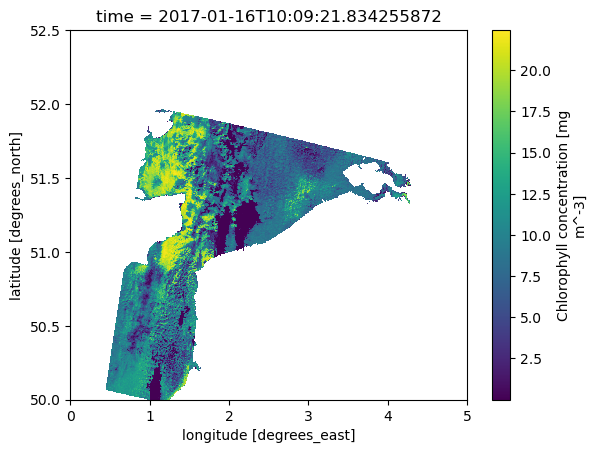

In [6]:
%%time
ds.analytic_conc_chl.isel(time=0).plot()

We can also add all open data parameters which are provided by xcube for the data type `dataset` and format ID `zarr`. To view all possible open parameters for different data types and format IDs, one can run the cell below.

In [7]:
%%time
store.get_open_data_params_schema()

CPU times: user 22 μs, sys: 1e+03 ns, total: 23 μs
Wall time: 25.7 μs


 The open parameters needs to be placed in a dictionary and given to the respective keyword argument. In the example below, we change the chunking of the represented data source.

In [8]:
%%time
ds = store.open_data(
    "collections/datacubes/items/local_ts",
    data_opener_open_params={
        "dataset:zarr": dict(chunks={"time": 5, "lat": 200, "lon": 400}),
    }
)
ds

CPU times: user 26.9 ms, sys: 1.07 ms, total: 27.9 ms
Wall time: 108 ms


/home/konstantin/micromamba/envs/xcube-stac/lib/python3.13/site-packages/xcube/core/store/fs/impl/dataset.py:174: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 200. This could degrade performance. Instead, consider rechunking after loading.
  dataset = xr.open_zarr(
/home/konstantin/micromamba/envs/xcube-stac/lib/python3.13/site-packages/xcube/core/store/fs/impl/dataset.py:174: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 400. This could degrade performance. Instead, consider rechunking after loading.
  dataset = xr.open_zarr(


<xarray.Dataset> Size: 400MB
Dimensions:                 (time: 5, lat: 1000, lon: 2000, bnds: 2)
Coordinates:
  * lat                     (lat) float64 8kB 52.5 52.5 52.49 ... 50.0 50.0
  * lon                     (lon) float64 16kB 0.00125 0.00375 ... 4.996 4.999
  * time                    (time) datetime64[ns] 40B 2017-01-16T10:09:21.834...
Dimensions without coordinates: bnds
Data variables:
    analytic_c2rcc_flags    (time, lat, lon) float64 80MB dask.array<chunksize=(5, 200, 400), meta=np.ndarray>
    analytic_conc_chl       (time, lat, lon) float64 80MB dask.array<chunksize=(5, 200, 400), meta=np.ndarray>
    analytic_conc_tsm       (time, lat, lon) float64 80MB dask.array<chunksize=(5, 200, 400), meta=np.ndarray>
    analytic_kd489          (time, lat, lon) float64 80MB dask.array<chunksize=(5, 200, 400), meta=np.ndarray>
    analytic_lat_bnds       (lat, bnds) float64 16kB dask.array<chunksize=(200, 2), meta=np.ndarray>
    analytic_lon_bnds       (lon, bnds) float64 32kB dask.array<chunksize=(400, 2), meta=np.ndarray>
    analytic_quality_flags  (time, lat, lon) float64 80MB dask.array<chunksize=(5, 200, 400), meta=np.ndarray>
    analytic_time_bnds      (time, bnds) datetime64[ns] 80B dask.array<chunksize=(5, 2), meta=np.ndarray>
Attributes:
    stac_catalog_url:  http://127.0.0.1:8080/ogc
    stac_item_id:      local_ts

Next, we can open a cloud-optimized GeoTIFF file, which allows to open it as usual `xarray.DataSet` or as [xcube's multi-resolution dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html).

Xcube server publishes each data resource as a `xarray.DataSet` and as [multi-resolution dataset](https://xcube.readthedocs.io/en/latest/mldatasets.html) with the asset names `"analytic"` and `"analytic_multires"`, respectively. If neither `opener_id` nor `data_type` is given in the `open_data` method, `"analytic"` is selected as default and a `xarray.DataSet` is returned, as shown below. 

In [9]:
%%time
ds = store.open_data("collections/datacubes/items/cog_local")
ds

CPU times: user 44 ms, sys: 1.08 ms, total: 45 ms
Wall time: 54.8 ms


<xarray.Dataset> Size: 3MB
Dimensions:          (y: 343, x: 343)
Coordinates:
  * x                (x) float64 3kB 4.001e+05 4.004e+05 ... 5.092e+05 5.096e+05
  * y                (y) float64 3kB 4e+06 4e+06 ... 3.891e+06 3.89e+06
    spatial_ref      int64 8B 0
Data variables:
    analytic_band_1  (y, x) float64 941kB dask.array<chunksize=(343, 343), meta=np.ndarray>
    analytic_band_2  (y, x) float64 941kB dask.array<chunksize=(343, 343), meta=np.ndarray>
    analytic_band_3  (y, x) float64 941kB dask.array<chunksize=(343, 343), meta=np.ndarray>
Attributes:
    stac_catalog_url:  http://127.0.0.1:8080/ogc
    stac_item_id:      cog_local

CPU times: user 30.4 ms, sys: 1.11 ms, total: 31.5 ms
Wall time: 33.6 ms


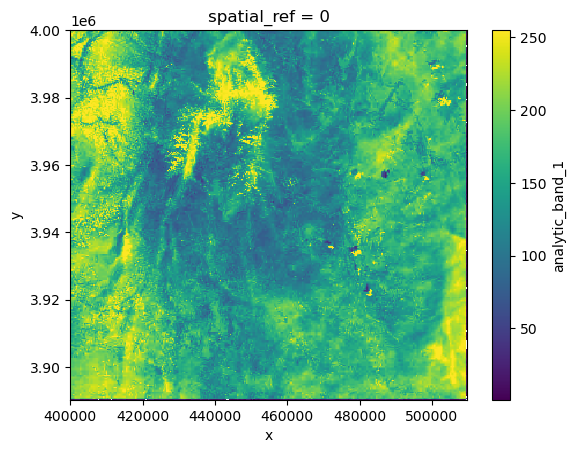

In [10]:
%%time
ds.analytic_band_1.plot()

To access the multi-resolution dataset, assign the parameter `data_type` to `"mldataset"` (or set `asset_names=["analytic_multires"]`).

In [11]:
%%time
mlds = store.open_data("collections/datacubes/items/cog_local", data_type="mldataset")
mlds.num_levels

CPU times: user 20.5 ms, sys: 6.11 ms, total: 26.6 ms
Wall time: 44.8 ms


3

Now, we can access a dataset with lower resolution. Note that the variable names in the dataset consists of the asset name and the variable name given in the loaded data resource. 

In [12]:
%%time
ds = mlds.get_dataset(2)
ds

CPU times: user 24.4 ms, sys: 1.95 ms, total: 26.3 ms
Wall time: 32.1 ms


<xarray.Dataset> Size: 179kB
Dimensions:                   (y: 86, x: 86)
Coordinates:
  * x                         (x) float64 688B 4.006e+05 4.019e+05 ... 5.091e+05
  * y                         (y) float64 688B 3.999e+06 3.998e+06 ... 3.891e+06
    spatial_ref               int64 8B 0
Data variables:
    analytic_multires_band_1  (y, x) float64 59kB dask.array<chunksize=(86, 86), meta=np.ndarray>
    analytic_multires_band_2  (y, x) float64 59kB dask.array<chunksize=(86, 86), meta=np.ndarray>
    analytic_multires_band_3  (y, x) float64 59kB dask.array<chunksize=(86, 86), meta=np.ndarray>
Attributes:
    stac_catalog_url:  http://127.0.0.1:8080/ogc
    stac_item_id:      cog_local

And we can plot the same image, but with the given lower resolution. 

CPU times: user 18 ms, sys: 2.16 ms, total: 20.2 ms
Wall time: 22.3 ms


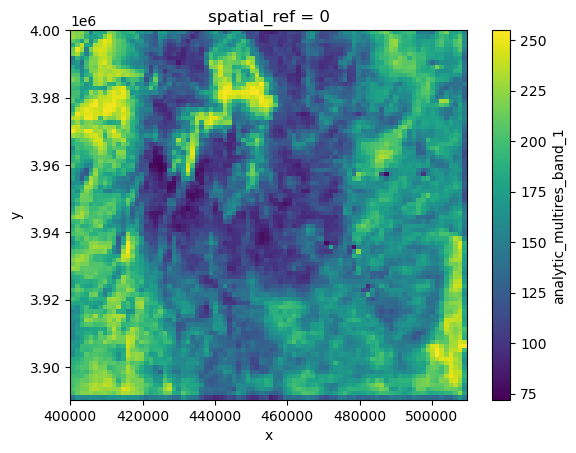

In [13]:
%%time
ds.analytic_multires_band_1.plot()